In [1]:
import os
os.chdir('..')
os.getcwd()

'/Users/signapoop/Desktop/fyp-graph-clustering'

In [2]:
%matplotlib inline
from timeit import default_timer as timer
import torch
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.metrics import mean_squared_error

In [3]:
from core.GraphConvNet2 import GraphConvNet2
from core.DataEmbeddingGraph import DataEmbeddingGraph
from util.mnist_data_loader import get_train_set, get_test_set
from util.plot_embedding import plot_embedding, plot_embedding_subplot
from util.draw_random_subset import draw_random_subset

cuda not available


In [4]:
def l2_norm(v):
    return np.sqrt(np.sum(np.square(v), axis=1, dtype=np.float64))

In [5]:
task_parameters = {}
task_parameters['flag_task'] = 'clustering'
task_parameters['reduction_method'] = 'spectral'
task_parameters['n_components'] = 2

net_parameters = {}
net_parameters['D'] = 784
net_parameters['n_components'] = task_parameters['n_components']
net_parameters['H'] = 50
net_parameters['L'] = 10

In [6]:
net = GraphConvNet2(net_parameters, task_parameters)


nb of hidden layers= 10
dim of layers (w/ embed dim)= [784, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]




In [7]:
# Load trained net
filename = 'results/mnist_net2.pkl'
checkpoint = torch.load(filename)
net.load_state_dict(checkpoint['state_dict'])

In [8]:
# Load mnist dataset
data_dir = 'data/mnist'
test_data = get_test_set(data_dir)

In [9]:
# Loss functions
def pairwise_loss_function_1(y_true, y_pred, W):
    pairwise_loss_1 = mean_squared_error(y_true[W.row,:], y_true[W.col,:])
    pairwise_loss_2 = mean_squared_error(y_pred[W.row,:], y_pred[W.col,:])
    return abs(pairwise_loss_1 - pairwise_loss_2)

def pairwise_loss_function_2(y_true, y_pred, W):
    pairwise_loss_1 = l2_norm(y_true[W.row,:] - y_true[W.col,:])
    pairwise_loss_2 = l2_norm(y_pred[W.row,:] - y_pred[W.col,:])
    return np.average(np.square(pairwise_loss_1 - pairwise_loss_2))

In [10]:
inputs, labels = draw_random_subset(test_data, num_samples=300)
inputs = inputs.view(inputs.shape[0],-1).numpy()
G = DataEmbeddingGraph(inputs, labels, task_parameters['reduction_method'])
net_time_start = timer()
y_pred = net.forward(G).detach().numpy()
net_time_end = timer()
G_tsne = DataEmbeddingGraph(inputs, labels, 'tsne')

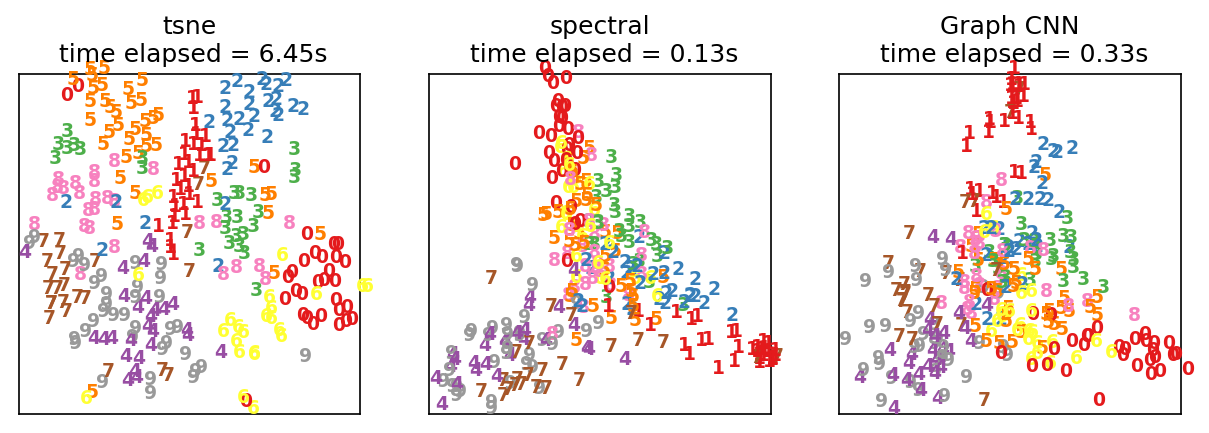

In [11]:
f, axarr = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(10, 3), dpi=150)
tsne_title = 'tsne' + "\n time elapsed = {:.2f}s".format(G_tsne.time_to_compute) 
spectral_title = 'spectral' + "\n time elapsed = {:.2f}s".format(G.time_to_compute) 
cnn_title = "Graph CNN" + "\n time elapsed = {:.2f}s".format(net_time_end - net_time_start) 
plot_embedding_subplot(axarr[0], G_tsne.target, G.labels.numpy(), tsne_title)
plot_embedding_subplot(axarr[1], G.target, G.labels.numpy(), spectral_title)
plot_embedding_subplot(axarr[2], y_pred, G.labels.numpy(), cnn_title)